# Libs, cuda, seed, params

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
import matplotlib.pyplot as plt
from datetime import datetime
from torch.nn.utils import clip_grad_norm_

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# parameters
RANDOM_SEED = 420
LEARNING_RATE = 0.01
BATCH_SIZE = 1
N_EPOCHS = 300
IMG_SIZE = 500

# Data

In [4]:
im_in_path = 'images/rgb/dog_cat_transf'
im_out_path = 'images/rgb/dog_cat'

In [5]:
def get_data(im_in_path, im_out_path):
    transform = T.Compose(transforms=[
        T.ToPILImage(),
        T.Resize(size=(IMG_SIZE, IMG_SIZE)),
        T.ToTensor()
    ])
    im_in = transform(read_image(im_in_path+".jpg"))
    im_out = transform(read_image(im_out_path+".jpg"))
    return im_in, im_out

In [6]:
class CustomTestDataset(Dataset):
    def __init__(self, image_in, image_out):
        self.img_labels = (image_in, image_out)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.img_labels[0], self.img_labels[1]

In [7]:
im_in, im_out = get_data(im_in_path, im_out_path)

In [8]:
train_loader = DataLoader(dataset=CustomTestDataset(im_in, im_out), 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

# Transform functions

In [7]:
def get_transform_matrix(theta, scale_factor, trans_x, trans_y, device):
    theta_cos = torch.cos(input=theta)
    theta_sin = torch.sin(input=theta)
    return torch.stack(tensors=[scale_factor*theta_cos, scale_factor * (-theta_sin), trans_x, scale_factor * theta_sin, scale_factor*theta_cos, trans_y]).view(2,3)


def transform_img(x, theta, scale_factor, trans_x, trans_y, device):
    scale_mat = get_transform_matrix(theta = theta, scale_factor=scale_factor, trans_x=trans_x, trans_y=trans_y,device=device).unsqueeze(dim=0).repeat(x.shape[0],1,1)    # repeat for whole batch
    grid = F.affine_grid(theta=scale_mat, size=x.size(), align_corners=False)
    x = F.grid_sample(input=x, grid=grid, align_corners=False)
    return x


def transform_img_with_matrix(x, trans_matrix):
    scale_mat = trans_matrix.view(2,3).unsqueeze(dim=0).repeat(x.shape[0],1,1)    # repeat for whole batch
    grid = F.affine_grid(theta=scale_mat, size=x.size(), align_corners=False)
    x = F.grid_sample(input=x, grid=grid, align_corners=False)
    return x

# Network

+ Functions

In [8]:
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:
        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=0.1)
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [9]:
def training_loop(model, criterion, optimizer, train_loader, epochs, device, print_every=50):
    train_losses = []
 
    for epoch in range(0, epochs):
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)
        
        if epoch % print_every == (print_every - 1):
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}')
    
    return model, optimizer, train_losses

+ Model

In [10]:
class AttentionTransformation(nn.Module):

    def __init__(self, device, img_size):
        super().__init__()
        
        self.device = device
        self.img_size = img_size
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(5,5), stride=(3,3)),
            nn.LeakyReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=(3,3)),
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=(2,2)),
            nn.BatchNorm2d(20),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=(3,3)),
            nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3, stride=(2,2)),
            
        )
        
        self.transf_ff = nn.Sequential(
            nn.Linear(in_features=270, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=4)
        )
        
        self.scale_ff = nn.Sequential(
            nn.Linear(in_features=4, out_features=1),
        )
        
        self.rot_ff = nn.Sequential(
            nn.Linear(in_features=4, out_features=1)
        )
        
        self.trans_x_ff = nn.Sequential(
            nn.Linear(in_features=4, out_features=1),
            nn.Tanh()
        ) 
            
        self.trans_y_ff = nn.Sequential(
            nn.Linear(in_features=4, out_features=1),
            nn.Tanh()
        )
        
        # zeroing transformation weights
        with torch.no_grad():
            self.transf_ff[0].weight.data.zero_()
            self.transf_ff[2].weight.data.zero_()            
            self.scale_ff[0].weight.data.zero_()            
            self.rot_ff[0].weight.data.zero_()            
            self.trans_x_ff[0].weight.data.zero_()                       
            self.trans_y_ff[0].weight.data.zero_()


    def forward(self, x_inp, is_evaling=False):
        x = self.feature_extractor(x_inp)
        x = torch.flatten(x, 1)
        trans = self.transf_ff(x)
        trans_x = self.trans_x_ff(trans)
        trans_y = self.trans_y_ff(trans)
        scale_factor = torch.exp(self.scale_ff(trans))
        rot_factor = self.rot_ff(trans)
        if is_evaling:
            print("Params:\n-Scale: " + str(scale_factor)+ "\n-Theta: " + str(rot_factor)+"\n-Trans_x: " + str(trans_x)+"\n-Trans_y: " + str(trans_y))
        trans_x =transform_img(x=x_inp, theta=rot_factor, scale_factor=scale_factor, device=self.device, trans_x=trans_x, trans_y=trans_y)
        return trans_x

In [13]:
torch.manual_seed(RANDOM_SEED)
model = AttentionTransformation(device,IMG_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss(reduction="mean")

In [14]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, N_EPOCHS, device, print_every=30)

02:00:51 --- Epoch: 29	Train loss: 0.0254
02:00:51 --- Epoch: 59	Train loss: 0.0240
02:00:52 --- Epoch: 89	Train loss: 0.0212
02:00:53 --- Epoch: 119	Train loss: 0.0201
02:00:54 --- Epoch: 149	Train loss: 0.0201
02:00:54 --- Epoch: 179	Train loss: 0.0201
02:00:55 --- Epoch: 209	Train loss: 0.0201
02:00:56 --- Epoch: 239	Train loss: 0.0201
02:00:57 --- Epoch: 269	Train loss: 0.0201
02:00:57 --- Epoch: 299	Train loss: 0.0201


# Evaluation

In [11]:
def evaluate_model(model, train_loader, device):
  img_inp, img_out = next(iter(train_loader))
  
  print("Proposed transformation", end=" ")
  with torch.no_grad():
    y = model(img_inp.to(device),is_evaling=True)
  
  print(f"Shape of prediction: {y.shape}")
  
  print(f"Images:")
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
  ax[0].title.set_text("Input")
  ax[0].imshow(img_inp.detach().cpu().squeeze(0).permute(1,2,0))
  ax[1].title.set_text("Prediction")
  ax[1].imshow(y.detach().cpu().squeeze(0).permute(1,2,0))
  ax[2].title.set_text("Target")
  ax[2].imshow(img_out.detach().cpu().squeeze(0).permute(1,2,0))
  plt.show()

Proposed transformation Params:
-Scale: tensor([[0.6600]], device='cuda:0')
-Theta: tensor([[-0.1957]], device='cuda:0')
-Trans_x: tensor([[0.2107]], device='cuda:0')
-Trans_y: tensor([[0.1278]], device='cuda:0')
Shape of prediction: torch.Size([1, 3, 500, 500])
Images:


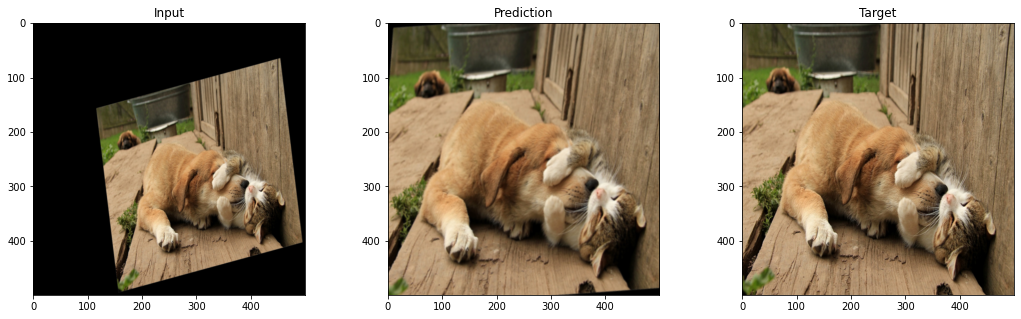

In [16]:
evaluate_model(model, train_loader, device)

# Another images

In [17]:
# parameters
RANDOM_SEED = 420
LEARNING_RATE = 0.001
BATCH_SIZE = 1
N_EPOCHS = 300
IMG_SIZE = 500

In [18]:
im_in_path2 = 'images/rgb/dog_cat_transf2'
im_out_path2 = 'images/rgb/dog_cat'

im_in2, im_out2 = get_data(im_in_path2, im_out_path2)
train_loader2 = DataLoader(dataset=CustomTestDataset(im_in2, im_out2), 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

In [19]:
torch.manual_seed(RANDOM_SEED)
model2 = AttentionTransformation(device,IMG_SIZE).to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=LEARNING_RATE)
criterion2 = nn.MSELoss(reduction="mean")

In [20]:
model2, optimizer2, _ = training_loop(model2, criterion2, optimizer2, train_loader2, N_EPOCHS, device, print_every=30)

02:01:04 --- Epoch: 29	Train loss: 0.1889
02:01:05 --- Epoch: 59	Train loss: 0.0656
02:01:06 --- Epoch: 89	Train loss: 0.0361
02:01:07 --- Epoch: 119	Train loss: 0.0382
02:01:08 --- Epoch: 149	Train loss: 0.0494
02:01:08 --- Epoch: 179	Train loss: 0.0343
02:01:09 --- Epoch: 209	Train loss: 0.0375
02:01:10 --- Epoch: 239	Train loss: 0.0337
02:01:10 --- Epoch: 269	Train loss: 0.0344
02:01:11 --- Epoch: 299	Train loss: 0.0351


Proposed transformation Params:
-Scale: tensor([[0.3476]], device='cuda:0')
-Theta: tensor([[0.5534]], device='cuda:0')
-Trans_x: tensor([[-0.4297]], device='cuda:0')
-Trans_y: tensor([[-0.3467]], device='cuda:0')
Shape of prediction: torch.Size([1, 3, 500, 500])
Images:


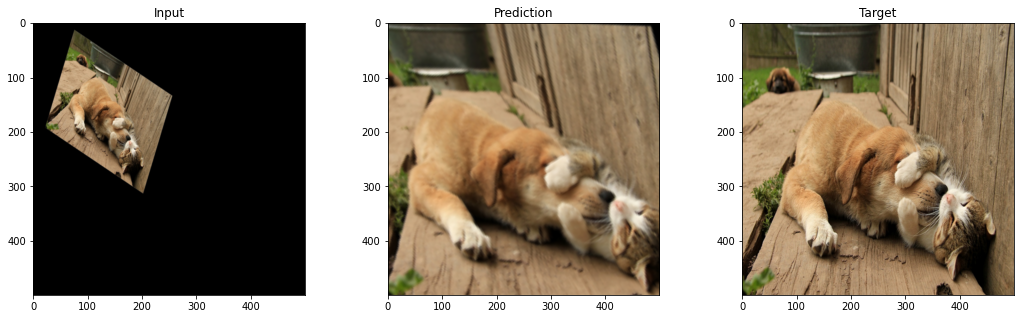

In [21]:
evaluate_model(model2, train_loader2, device)